In [23]:
from tensorflow.keras import layers
from tensorflow import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

EPOCH = 100
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [24]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

# Pre-processing data

In [25]:
wellbeing = pd.read_csv('./data/Wellbeing_and_lifestyle_data_Kaggle.csv')
wellbeing = wellbeing.drop('Timestamp', axis=1)
wellbeing = wellbeing.drop([10005]) 

age_dict = {'Less than 20' : 1, '21 to 35' : 2, '36 to 50' : 3, '51 or more' : 4}
wellbeing['AGE'] = pd.Series([age_dict[x] for x in wellbeing.AGE], index=wellbeing.index)

gender_dict = {'Female' : 1, 'Male' : 0}
wellbeing['GENDER'] = pd.Series([gender_dict[x] for x in wellbeing.GENDER], index=wellbeing.index)

wellbeing['DAILY_STRESS'] = wellbeing['DAILY_STRESS'].astype(int)

X = wellbeing.drop(['DAILY_STRESS', 'ACHIEVEMENT'], axis=1)
y = wellbeing[['DAILY_STRESS', 'ACHIEVEMENT']]

In [26]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 42, test_size=0.33)
print(f'''
Train X shape : {train_X.shape}
Train y shape : {train_y.shape}

Test X shape : {val_X.shape}
Test y shape : {val_y.shape}
''')


Train X shape : (10700, 21)
Train y shape : (10700, 2)

Test X shape : (5271, 21)
Test y shape : (5271, 2)



# Data Anayslsis

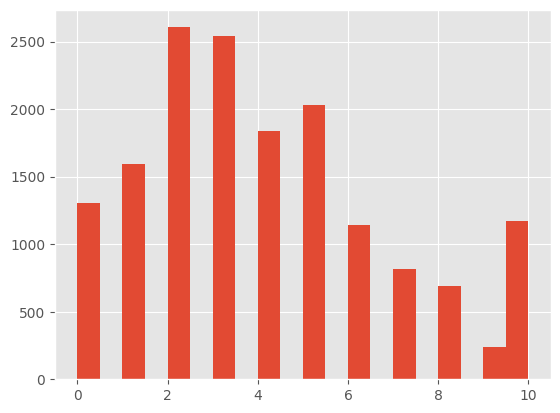

In [31]:
plt.hist(y['ACHIEVEMENT'], bins=20)
plt.show()

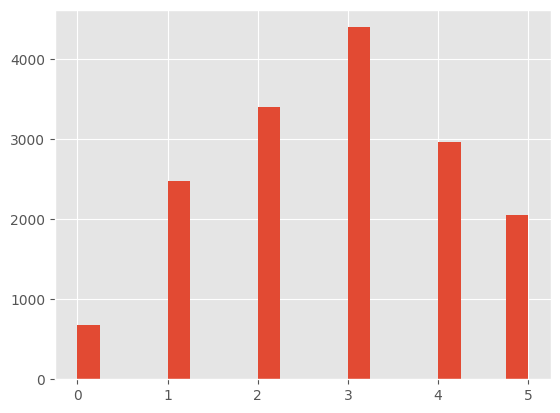

In [32]:
plt.hist(y['DAILY_STRESS'], bins=20)
plt.show()

In [36]:
y_achievement_cate = list()
for value in tqdm(y['ACHIEVEMENT']):
    if value < 2:
        y_achievement_cate.append([1, 0, 0, 0, 0, 0])

    elif 2 <= value and value < 4:
        y_achievement_cate.append([0, 1, 0, 0, 0, 0])

    elif 4 <= value and value < 6:
        y_achievement_cate.append([0, 0, 1, 0, 0, 0])

    elif 6 <= value and value < 8:
        y_achievement_cate.append([0, 0, 0, 1, 0, 0])

    elif 8 <= value and value < 10:
        y_achievement_cate.append([0, 0, 0, 0, 1, 0])

    else:
        y_achievement_cate.append([0, 0, 0, 0, 0, 1])

y_achievement_cate = np.array(y_achievement_cate)
print(f"y_achievement category array shape : {y_achievement_cate.shape}")

100%|██████████| 15971/15971 [00:00<00:00, 1656377.76it/s]

y_achievement category array shape : (15971, 6)


In [38]:
y_daily_stress_cate = list()

for value in tqdm(y['DAILY_STRESS']):
    if value == 0:
        y_daily_stress_cate.append([1, 0, 0, 0, 0, 0])

    elif value == 1:
        y_daily_stress_cate.append([0, 1, 0, 0, 0, 0])

    elif value == 2:
        y_daily_stress_cate.append([0, 0, 1, 0, 0, 0])

    elif value == 3:
        y_daily_stress_cate.append([0, 0, 0, 1, 0, 0])

    elif value == 4:
        y_daily_stress_cate.append([0, 0, 0, 0, 1, 0])

    else:
        y_daily_stress_cate.append([0, 0, 0, 0, 0, 1])

y_daily_stress_cate = np.array(y_daily_stress_cate)
print(f"y_daily_stress_category shape : {y_daily_stress_cate.shape}")


100%|██████████| 15971/15971 [00:00<00:00, 1961041.87it/s]

y_daily_stress_category shape : (15971, 6)


# Model building

In [ ]:
lefms = keras.Sequential([
    layers.Conv1D(64, 3, padding='same', input_shape=(21, 1)),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),

    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(32, 3, padding='same'),
    layers.Conv1D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(32, 3, padding='same'),
    layers.Conv1D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(16, 3, padding='same'),
    layers.Conv1D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),

    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(2, activation='tanh')
])

In [ ]:
adam = keras.optimizers.Adam(
        learning_rate=0.000001
)

lefms.compile(
        optimizer=adam,
        loss='binary_crossentropy',
        metrics=['accuracy']
)

lefms.summary()

In [ ]:
outDir = './cheakpoint/lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'
def get_callbacks(patience = 50):
    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
  
    # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
    callbacks = [model_checkpoint]

    return callbacks

In [ ]:
callbacks = get_callbacks()
model_history = lefms.fit(
    train_X, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_data=(val_X, val_y),
    callbacks=[callbacks]
)

# Visualization results

In [ ]:
plot_model__hist(model_history)
loss,acc = lefms.evaluate(val_X, val_y, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# Recall models, test

In [ ]:
model_saved_path = './cheakpoint/lefms_model/'

recall_model_path = model_saved_path + sorted(os.listdir(model_saved_path))[-1]
reconstructed_model = keras.models.load_model(recall_model_path)
print(f"Recalled model path : {recall_model_path}")

In [ ]:
y_pred = reconstructed_model.predict(val_X)

In [ ]:
print(val_y)

In [ ]:
print(y_pred)